Đang training model... (Đợi xíu)
--> Training xong!


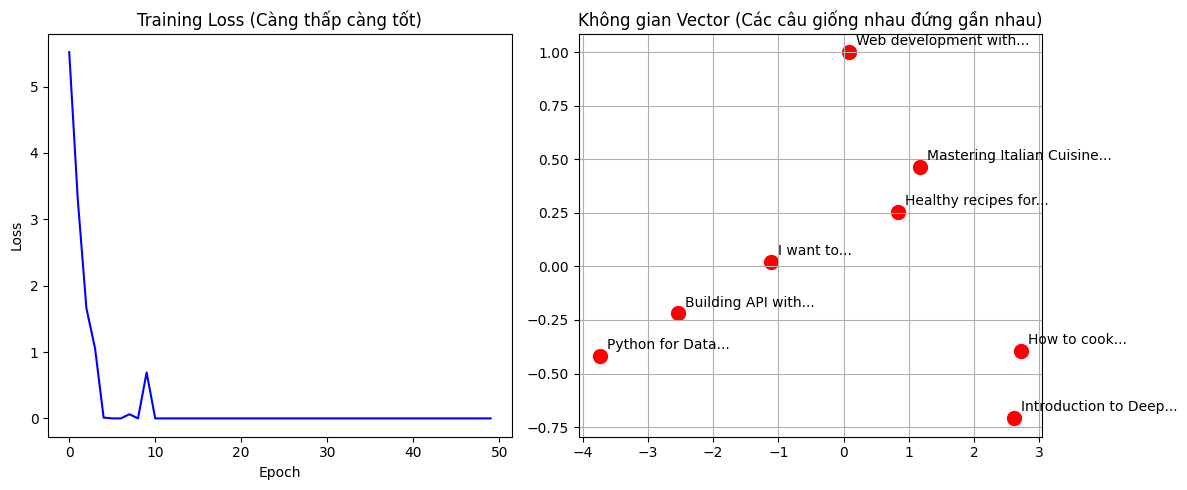


User muốn: 'I want to learn cooking pasta'
--> Gợi ý: 'Mastering Italian Cuisine' (Distance: 0.4626)

User muốn: 'Teach me python programming'
--> Gợi ý: 'I want to learn python programming' (Distance: 0.3410)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# ==========================================
# 1. DỮ LIỆU GIẢ LẬP (DATASET)
# ==========================================
# Giả lập các câu liên quan đến: CODE (Python/Web) và NẤU ĂN (Cooking)
all_sentences = [
    "I want to learn python programming", 
    "Python for Data Science Course", 
    "How to cook spaghetti",
    "Introduction to Deep Learning",
    "Web development with React",
    "Healthy recipes for dinner",
    "Building API with Django",
    "Mastering Italian Cuisine"
]

# Vector hóa đơn giản (Đếm từ)
vectorizer = CountVectorizer(stop_words='english', max_features=100)
vectorizer.fit(all_sentences)
INPUT_DIM = len(vectorizer.get_feature_names_out())

# Hàm chuyển chữ thành số (Tensor)
def text_to_tensor(text):
    vec = vectorizer.transform([text]).toarray()
    return torch.tensor(vec, dtype=torch.float32)

# Dữ liệu bộ ba (Anchor, Positive, Negative) để dạy Model
# Cấu trúc: [Người dùng muốn, Khóa học đúng, Khóa học sai]
triplets_data = [
    ("I want to learn python", "Python for Data Science Course", "How to cook spaghetti"),
    ("I want to learn python", "Building API with Django", "Mastering Italian Cuisine"),
    ("I want to learn web", "Web development with React", "Introduction to Deep Learning"),
    ("I want to learn cooking", "Healthy recipes for dinner", "Python for Data Science Course"),
    ("I want to learn cooking", "Mastering Italian Cuisine", "Building API with Django")
]

# ==========================================
# 2. XÂY DỰNG MODEL (SIAMESE NETWORK)
# ==========================================
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        # Mạng Neural 2 lớp đơn giản
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64), # Lớp ẩn
            nn.ReLU(),
            nn.Linear(64, 16)         # Output vector 16 chiều
        )

    def forward_one(self, x):
        return self.fc(x)

    def forward(self, anchor, pos, neg):
        out_a = self.forward_one(anchor)
        out_p = self.forward_one(pos)
        out_n = self.forward_one(neg)
        return out_a, out_p, out_n

model = SiameseNetwork(INPUT_DIM)

# ==========================================
# 3. HUẤN LUYỆN (TRAINING LOOP)
# ==========================================
criterion = nn.TripletMarginLoss(margin=1.0) # Hàm mất mát
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = []
epochs = 50

print("Đang training model... (Đợi xíu)")
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for a_txt, p_txt, n_txt in triplets_data:
        # Chuyển text sang tensor
        anchor = text_to_tensor(a_txt)
        pos = text_to_tensor(p_txt)
        neg = text_to_tensor(n_txt)
        
        optimizer.zero_grad()
        out_a, out_p, out_n = model(anchor, pos, neg)
        loss = criterion(out_a, out_p, out_n)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print("--> Training xong!")

# ==========================================
# 4. VẼ BIỂU ĐỒ (VISUALIZATION)
# ==========================================
plt.figure(figsize=(12, 5))

# Biểu đồ 1: Loss Curve (Chứng minh model đã học)
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='blue')
plt.title('Training Loss (Càng thấp càng tốt)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Biểu đồ 2: Không gian Vector (PCA)
# Lấy vector đặc trưng của tất cả câu
vecs = []
for txt in all_sentences:
    t = text_to_tensor(txt)
    with torch.no_grad():
        v = model.forward_one(t).numpy()[0]
    vecs.append(v)
vecs = np.array(vecs)

# Giảm chiều xuống 2D để vẽ
pca = PCA(n_components=2)
coords = pca.fit_transform(vecs)

plt.subplot(1, 2, 2)
plt.scatter(coords[:, 0], coords[:, 1], c='red', s=100)

# Gán tên cho từng điểm
for i, txt in enumerate(all_sentences):
    label = txt.split()[:3] # Lấy 3 chữ đầu cho ngắn
    label = " ".join(label) + "..."
    plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), textcoords='offset points')

plt.title('Không gian Vector (Các câu giống nhau đứng gần nhau)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 5. TEST THỬ GỢI Ý
# ==========================================
def recommend(query):
    query_vec = model.forward_one(text_to_tensor(query))
    scores = {}
    for course in all_sentences:
        course_vec = model.forward_one(text_to_tensor(course))
        dist = torch.dist(query_vec, course_vec).item() # Khoảng cách Euclid
        scores[course] = dist
    
    # Sắp xếp (Khoảng cách nhỏ nhất lên đầu)
    best_match = min(scores, key=scores.get)
    print(f"\nUser muốn: '{query}'")
    print(f"--> Gợi ý: '{best_match}' (Distance: {scores[best_match]:.4f})")

recommend("I want to learn cooking pasta")
recommend("Teach me python programming")